In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("insurance.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   bmi       1338 non-null   float64
 2   children  1338 non-null   int64  
 3   charges   1338 non-null   float64
dtypes: float64(2), int64(2)
memory usage: 41.9 KB


**Helper Functions and Preprocessing**

In [157]:
def normalize(x):
    return (x - x.mean(axis=0)) / x.std(axis=0)

def add_bias(x):
    return np.c_[np.ones(x.shape[0]), x]

def mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def plot_error(history, title):
    plt.figure(figsize=(10, 6))
    plt.plot(history, label=title)
    plt.xlabel("Iteration")
    plt.ylabel("Error")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()


X = data.iloc[:, :-1].values
Y = data.iloc[:, -1]

# X = normalize(X)
X = add_bias(X)

m = len(Y)
split_ratio = 0.8
random_seed = np.random.seed(10)
indices = np.random.permutation(m)
split_index = int(split_ratio * m)

train_indices = indices[:split_index]
test_indices = indices[split_index:]

X_train = X[train_indices]
X_test = X[test_indices]

y_train = np.array(Y[train_indices])
y_test = np.array(Y[test_indices])

**GD**

iteration 100, mse loss: 133082972.18947132
iteration 200, mse loss: 132023457.14821643
iteration 300, mse loss: 131986197.39755186
iteration 400, mse loss: 131959092.1887608
iteration 500, mse loss: 131936246.19033574


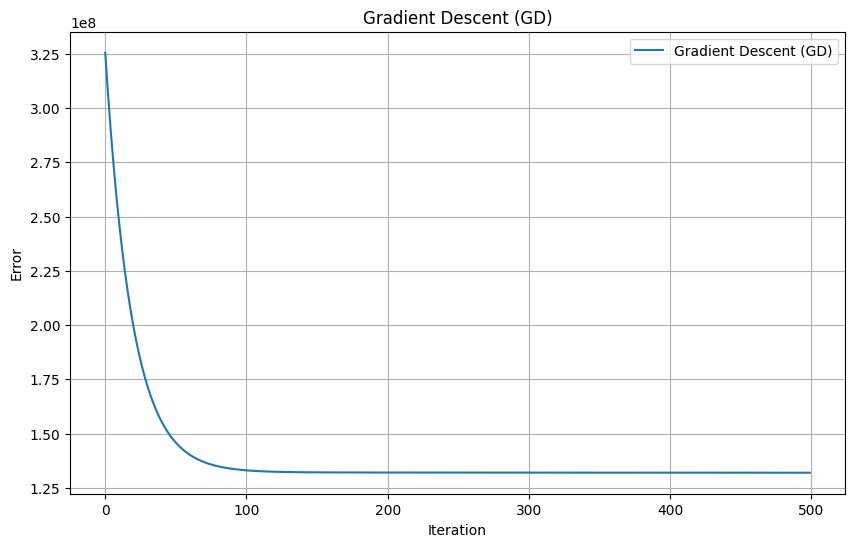

In [175]:
def gradient_descent(x, y, lr=0.00001, epoch=500, random_weight=False):
    m, n = x.shape
    err_history = []
    if not random_weight:
        w = np.zeros(n)
    else:
        np.random.seed(10)
        w = np.random.randn(n)

    for i in range(epoch):
        y_pred = x @ w

        mse_err = mse(y, y_pred)
        err_history.append(mse_err)

        # 1/m sum(y_pred - y_true) Xij
        error = y_pred - y
        gradient = (x.T.dot(error)) / m

        w = w - (lr*gradient)

        if (i+1) % 100 == 0:
            print(f"iteration {i+1}, mse loss: {mse_err}")

    return w, err_history

gd_weights, gd_history = gradient_descent(X_train, y_train, random_weight=False)
plot_error(gd_history, "Gradient Descent (GD)")


**SGD**

iteration 1, mse loss: 132477853.43997882
iteration 2, mse loss: 132049062.40864092


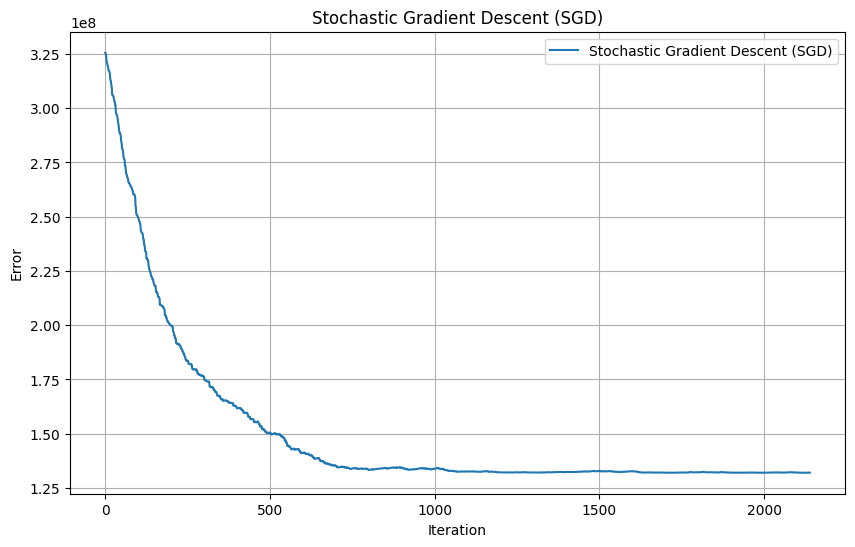

In [208]:
def sgd(x, y, lr=0.000001, epoch=2, random_weight=False):
    m, n = x.shape
    err_history = []
    err_history_epoch = []
    if not random_weight:
        w = np.zeros(n)
    else:
        np.random.seed(10)
        w = np.random.randn(n)

    for e in range(epoch):
        err_history_epoch.append(mse(y, x@w))
        
        for i in range(m):
            xi = x[i, :].reshape(1, -1)
            yi = y[i]

            y_pred = xi.dot(w)

            mse_err = mse(y, x@w)
            err_history.append(mse_err)

            error = y_pred - yi
            gradient = xi.T.dot(error)

            w -= lr*gradient.flatten()

        print(f"iteration {e+1}, mse loss: {mse_err}")

    return w, err_history, err_history_epoch

sgd_weights, sgd_history, sgd_history_epoch = sgd(X_train, y_train)
plot_error(sgd_history, "Stochastic Gradient Descent (SGD)")

**Why there are fluctuations in SGD:** In each iteration of SGD, only a single data point is used to compute the gradient and update the weights. This approach makes the gradient updates noisier because each sample might pull the weights in a different direction, causing fluctuations in the error.

**mini-batch GD**

iteration 1, mse loss: 144712699.6955499
iteration 2, mse loss: 132478894.02070412
iteration 3, mse loss: 132066041.75886679
iteration 4, mse loss: 132014803.30810928
iteration 5, mse loss: 131998996.01783207
iteration 6, mse loss: 131981191.07005313
iteration 7, mse loss: 131969320.9046667
iteration 8, mse loss: 131951659.30013362
iteration 9, mse loss: 132087475.46113624
iteration 10, mse loss: 131928805.97132449


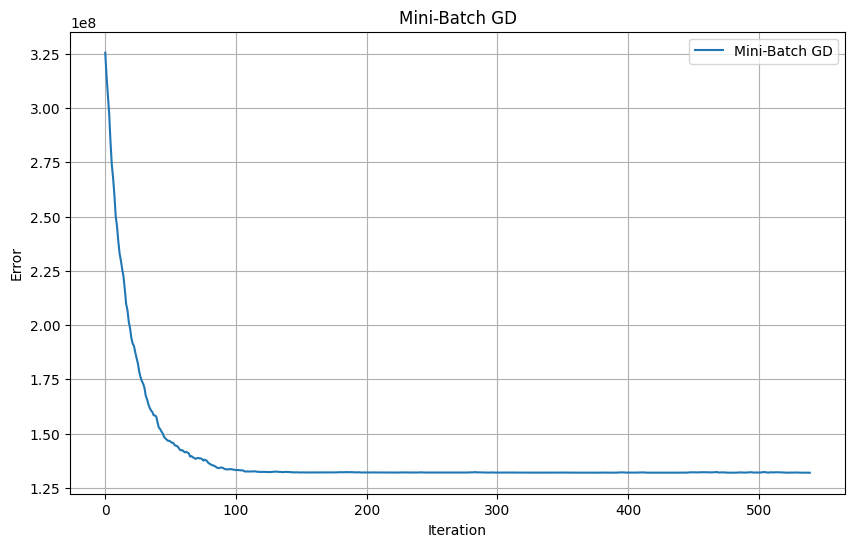

In [173]:
def mini_batch_gd(x, y, lr=0.00001, epoch=10, batch_size=20, random_weight=False):
    m, n = x.shape
    err_history = []
    err_history_epoch = []
    
    if not random_weight:
        w = np.zeros(n)
    else:
        np.random.seed(10)
        w = np.random.randn(n)

    for e in range(epoch):
        err_history_epoch.append(mse(y, x.dot(w)))
        
        indices = np.random.permutation(m)
        x = x[indices]
        y = y[indices]
        
        for i in range(0, m, batch_size):
            xi = x[i:i + batch_size]
            yi = y[i:i + batch_size]

            y_pred = xi @ w

            mse_err = mse(y, x.dot(w))
            err_history.append(mse_err)

            error = y_pred - yi
            gradient = xi.T.dot(error) / batch_size

            w -= lr*gradient

        
        print(f"iteration {e+1}, mse loss: {mse_err}")

    return w, err_history, err_history_epoch

mbgd_weights, mbgd_history, mbgd_history_epoch = mini_batch_gd(X_train, y_train)
plot_error(mbgd_history, "Mini-Batch GD")
            

**Why there are fluctuations in SGD:** There tiny fluctuations in mini-batch gradient descent that occur due to the random sampling of mini-batches, which introduces variability and noise in the gradient estimates, influenced by batch size and learning rate.

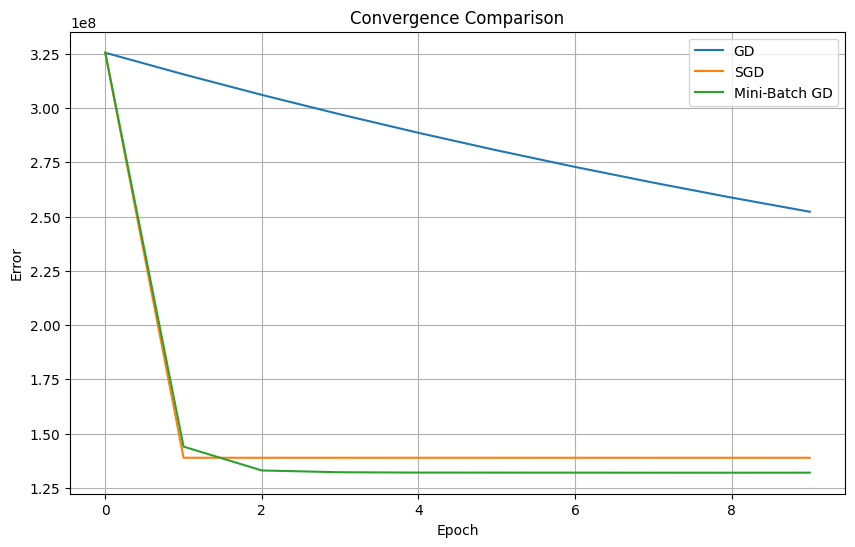

In [171]:
plt.figure(figsize=(10, 6))
plt.plot(gd_history, label="GD")
plt.plot(sgd_history_epoch, label="SGD")
plt.plot(mbgd_history_epoch, label="Mini-Batch GD")
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.title("Convergence Comparison")
plt.legend()
plt.grid(True)
plt.show()


***Gradient Descent:***
Uses the entire dataset to compute the gradient for each update.
This means each update is precise but can be slower in terms of runtime, especially for large datasets.
GD usually shows a smooth error curve but may take more iterations to converge (500 epochs in this case).

***Stochastic Gradient Descent:***
Uses only one data point at each step to compute the gradient.
This makes the updates noisy, causing fluctuations in the error at each step.
SGD can converge faster in terms of iterations because it updates the weights more frequently, but it may not achieve the same minimum error as GD due to the noisy updates.

***Mini-Batch Gradient Descent (MBGD):***
Uses a subset (batch) of the dataset for each update, which is a balance between GD and SGD.
MBGD generally achieves faster convergence than GD while reducing the noise present in SGD.
It’s more stable than SGD and often reaches a lower minimum error compared to SGD, especially when the batch size is well-tuned.

So based on the plot above, I compared the speed and convergance of these three methods for 10 epochs and as we can see SGD is the fastest method then mini-batch GD and at last GD. and the minimum error is achived by mini_batch GD then SGD and at last GD 

In [179]:
gd_zero_weights, gd_zero_history = gradient_descent(X_train, y_train, random_weight=False)

iteration 100, mse loss: 133082972.18947132
iteration 200, mse loss: 132023457.14821643
iteration 300, mse loss: 131986197.39755186
iteration 400, mse loss: 131959092.1887608
iteration 500, mse loss: 131936246.19033574


In [181]:
gd_random_weights, gd_random_history = gradient_descent(X_train, y_train, random_weight=True)

iteration 100, mse loss: 133099644.93213649
iteration 200, mse loss: 132035583.31291692
iteration 300, mse loss: 131996451.57976742
iteration 400, mse loss: 131967783.66630118
iteration 500, mse loss: 131943625.01401193


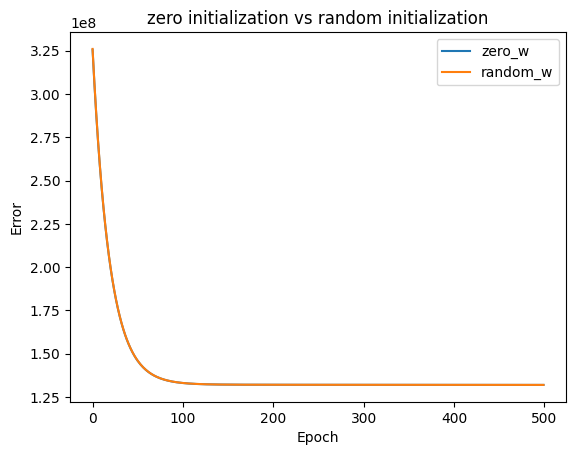

In [178]:
plt.plot(gd_zero_history, label="zero_w")
plt.plot(gd_random_history, label="random_w")
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.title("zero initialization vs random initialization")
plt.legend()
plt.show()

Initiaizing weights with zero end up in the `131936246` loss and with random it ended up in `131943625` which is slightly wors here for random initilization but not that visible in the plot. but generally random initialization is better because it helps break the symmetry and help model to learn diverse festures.

**SGD with MAE loss**

Iteration 1, MAE loss: 7374.54714833458
Iteration 2, MAE loss: 7268.069365625237
there are 0 non differentiable points in the dataset


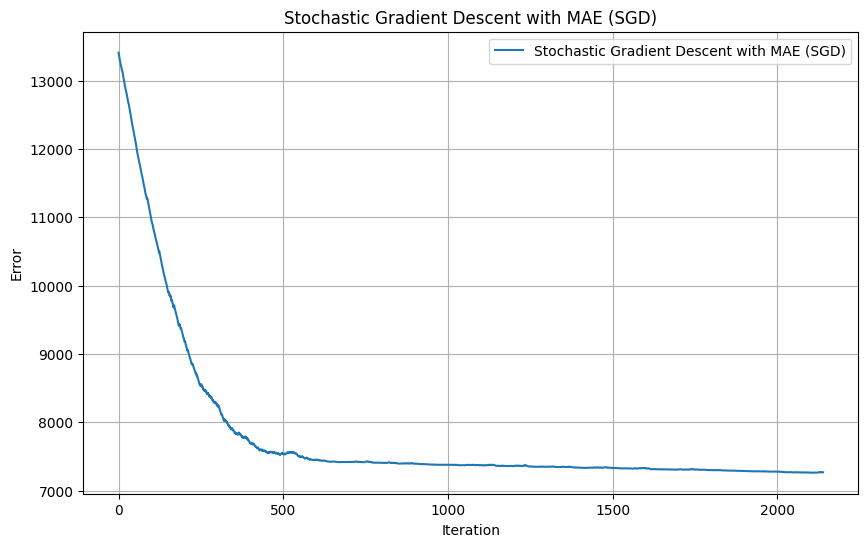

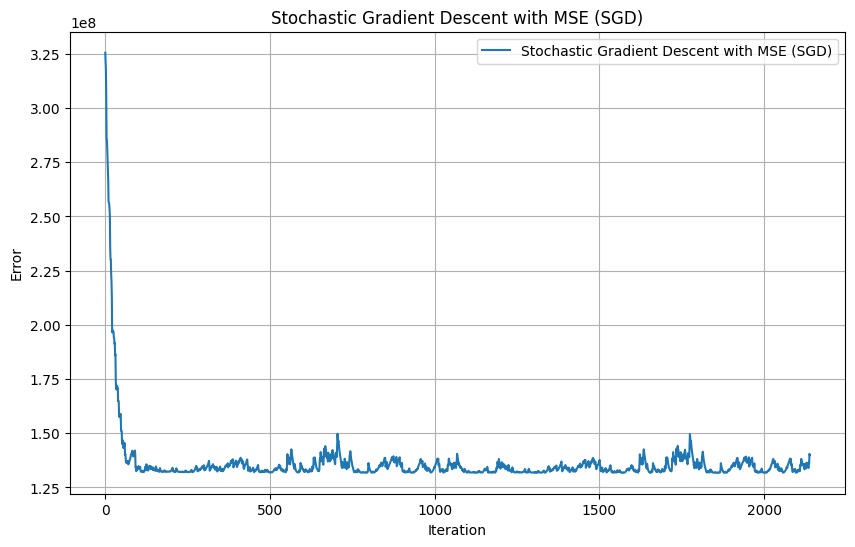

In [182]:
def sgd(x, y, lr=0.01, epoch=2, random_weight=False):
    m, n = x.shape
    err_history = []
    err_history_epoch = []
    non_differentiable_points = 0
    
    if not random_weight:
        w = np.zeros(n)
    else:
        np.random.seed(10)
        w = np.random.randn(n)

    for e in range(epoch):
        err_history_epoch.append(mse(y, x@w))
        
        for i in range(m):
            xi = x[i, :].reshape(1, -1)
            yi = y[i]

            y_pred = xi.dot(w)

            mae_err = mae(y, x@w)
            err_history.append(mae_err)

            # using sub-gradient for MAE
            error = y_pred - yi
            if error == 0:
                non_differentiable_points += 1
            gradient = np.sign(error) * xi.T 

            w -= lr*gradient.flatten()

        
        print(f"Iteration {e+1}, MAE loss: {mae_err}")

    return w, err_history, err_history_epoch, non_differentiable_points

sgd_weights, sgd_mae_history, sgd_mae_history_epoch, non_differentiable_points = sgd(X_train, y_train)
print(f"there are {non_differentiable_points} non differentiable points in the dataset")
plot_error(sgd_mae_history, "Stochastic Gradient Descent with MAE (SGD)")
plot_error(sgd_history, "Stochastic Gradient Descent with MSE (SGD)")

**MAE Loss:** Instead of MSE, which is `(1/m) ∑ (y - y_pred)^2`, the MAE loss is `(1/m) ∑ |y - y_pred|`.

**Gradient Calculation for MAE**: Since the MAE function uses an absolute value, the gradient of MAE is not continuous. For MAE, the gradient is:
     \[
     \text{grad} = 
     \begin{cases} 
      -1 & \text{if } y - y_{\text{pred}} > 0 \\
      +1 & \text{if } y - y_{\text{pred}} < 0 \\
      0 & \text{if } y - y_{\text{pred}} = 0 
     \end{cases}
     
For efficient computation, we can use `np.sign(y - y_pred)`, which returns -1, 0, or 1 as required.


**MSE**: Tends to penalize larger errors more heavily, leading to potentially larger updates when errors are high.

**MAE**: Treats all errors equally, which can make it less sensitive to outliers but may converge more slowly.

iteration 100, mse loss: 1.9896940328412517e+49
iteration 200, mse loss: 5.312410620257205e+90
iteration 300, mse loss: 1.4183942924089664e+132
iteration 400, mse loss: 3.787061115092977e+173
iteration 500, mse loss: 1.0111315285322803e+215


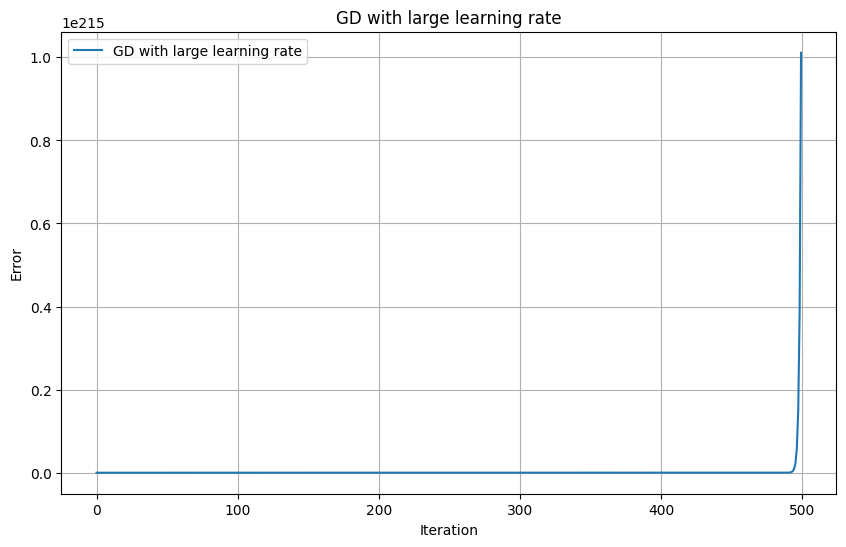

In [186]:
large_lr = 0.001
gd_large_lr_weights, gd_large_lr_history = gradient_descent(X_train, y_train, lr=large_lr)
plot_error(gd_large_lr_history, "GD with large learning rate")

As we can see by choosing a large learning rate, in this case `0.001` which is high, the model wont converge and the mse loss will increase significantly after some iterations.

iteration 100, mse loss: 315792513.01844275
iteration 200, mse loss: 306444122.1817632
iteration 300, mse loss: 297571437.8649892
iteration 400, mse loss: 289150251.8617834
iteration 500, mse loss: 281157587.89809835


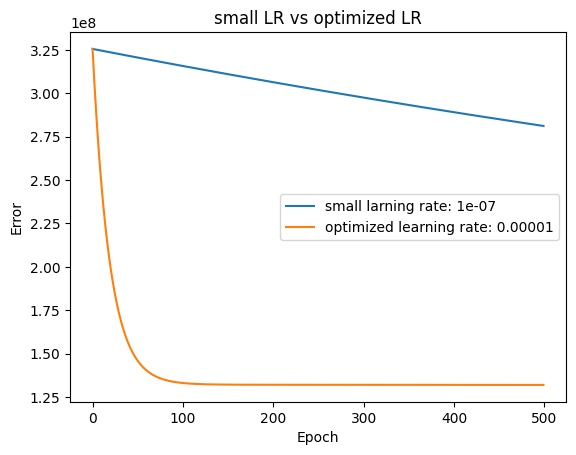

In [191]:
small_lr = 0.0000001
gd_small_lr_weights, gd_small_lr_history = gradient_descent(X_train, y_train, lr=small_lr)

plt.plot(gd_small_lr_history, label=f"small larning rate: {small_lr}")
plt.plot(gd_history, label="optimized learning rate: 0.00001")
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.title("small LR vs optimized LR")
plt.legend()
plt.show()

In [196]:
X

array([[ 1.  , 19.  , 27.9 ,  0.  ],
       [ 1.  , 18.  , 33.77,  1.  ],
       [ 1.  , 28.  , 33.  ,  3.  ],
       ...,
       [ 1.  , 18.  , 36.85,  0.  ],
       [ 1.  , 21.  , 25.8 ,  0.  ],
       [ 1.  , 61.  , 29.07,  0.  ]])

iteration 1, mse loss: 150164260.01571405
iteration 2, mse loss: 150164942.6376317


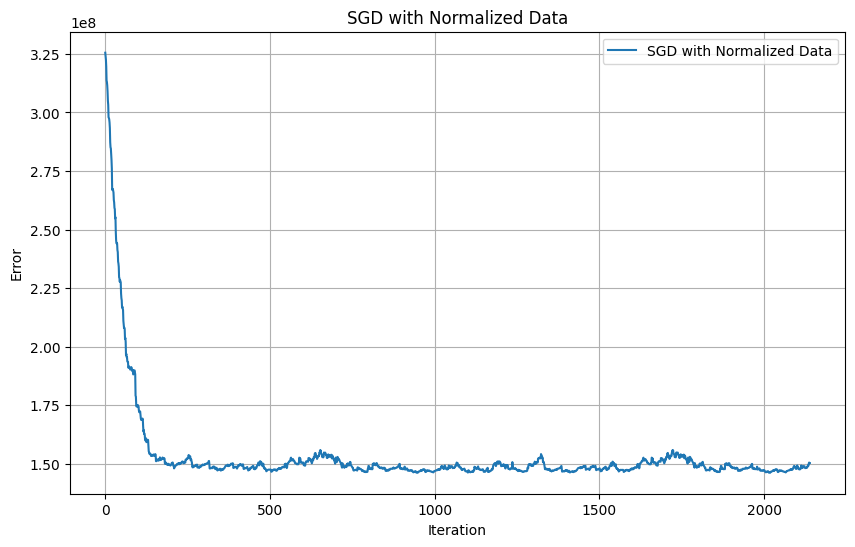

In [205]:
X_bias = X[:, 0].reshape(-1, 1)  
X_features = X[:, 1:]  

X_features_normalized = normalize(X_features)

# Combine the bias term with the normalized features
X_normalized = np.hstack((X_bias, X_features_normalized))
X_train_norm, X_test_norm = X_normalized[:split_index], X_normalized[split_index:]

sgd_weights_norm, sgd_history_norm, sgd_history_norm_epoch = sgd(X_train_norm, y_train, lr=0.01)
plot_error(sgd_history_norm, "SGD with Normalized Data")

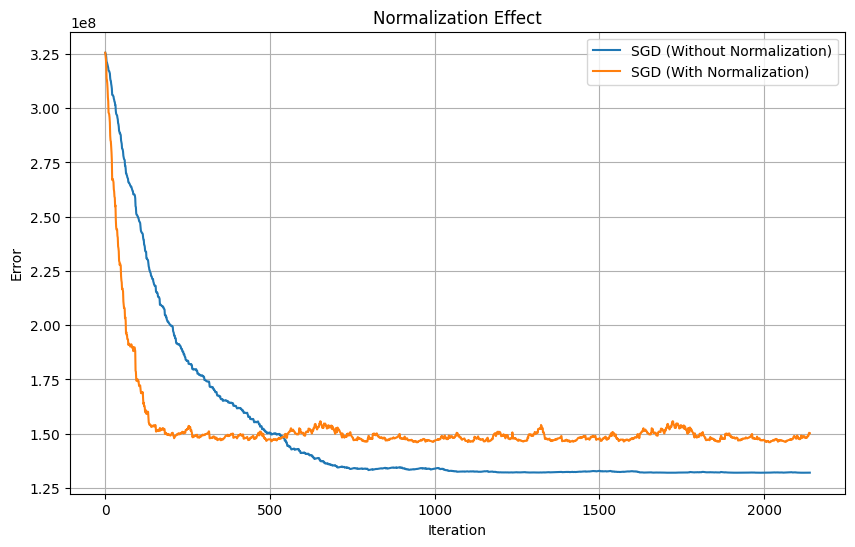

In [209]:
plt.figure(figsize=(10, 6))
plt.plot(sgd_history, label="SGD (Without Normalization)")
plt.plot(sgd_history_norm, label="SGD (With Normalization)")
plt.xlabel("Iteration")
plt.ylabel("Error")
plt.title("Normalization Effect")
plt.legend()
plt.grid(True)
plt.show()

In this dataset the speed of normalized data convergence is higher but the accuracy of unnormalized data apparantly is better.